<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
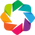

In [1]:
from pathlib import Path
import xarray as xr
import clearwater_riverine as cwr

In [2]:
project_path = Path.cwd().parent
src_path = project_path / 'src'
print(project_path)
print(src_path)

#point to config
network_path = Path(r'W:\2ERDC12 - Clearwater\Clearwater_testing_NSM\plan_48_simulation')
wetted_surface_area_path = network_path / "wetted_surface_area.zarr"
q_solar_path = network_path / 'cwr_boundary_conditions_q_solar_p28.csv'
air_temp_path = network_path / 'cwr_boundary_conditions_TairC_p28.csv'
config_file = network_path / 'demo_config.yml'
print(config_file.exists())

start_index =  0 # int((8*60*60)/30)
end_index = 15  # 48*60*60
print(start_index, end_index)

transport_model = cwr.ClearwaterRiverine(
    config_filepath=config_file,
    verbose=True,
    datetime_range= (start_index, end_index)
)

c:\Users\sjordan\OneDrive - LimnoTech\Documents\GitHub\ClearWater-riverine\examples
c:\Users\sjordan\OneDrive - LimnoTech\Documents\GitHub\ClearWater-riverine\examples\src
True
0 15
Populating Model Mesh...
Calculating Required Parameters...


In [3]:
from clearwater_riverine.utilities import calculate_wetted_surface_area

In [4]:
lookup_dataset = calculate_wetted_surface_area(
    transport_model.mesh
)

C:\Users\sjordan\OneDrive - LimnoTech\Documents\GitHub\ClearWater-riverine\src\clearwater_riverine\utilities.py:588: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.full((mesh.dims[TIME], mesh.dims[FACES]), np.nan),


In [5]:
lookup_dataset

<xarray.Dataset>
Dimensions:              (nface: 444, lookup: 33)
Coordinates:
  * nface                (nface) int64 0 1 2 3 4 5 6 ... 438 439 440 441 442 443
  * lookup               (lookup) int32 0 1 2 3 4 5 6 7 ... 26 27 28 29 30 31 32
Data variables:
    volume               (nface, lookup) float32 0.0 7.313 13.2 ... nan nan nan
    wetted_surface_area  (nface, lookup) float32 0.0 247.4 513.7 ... nan nan nan

In [6]:
# open previously calculated
wetted_sa = xr.open_zarr(wetted_surface_area_path)
wetted_sa = wetted_sa.compute()
wetted_sa_subset = wetted_sa.isel(time=slice(start_index, end_index+1))

In [7]:
wetted_sa

<xarray.Dataset>
Dimensions:              (nface: 444, time: 5761)
Coordinates:
  * nface                (nface) int32 0 1 2 3 4 5 6 ... 438 439 440 441 442 443
  * time                 (time) int32 0 1 2 3 4 5 ... 5756 5757 5758 5759 5760
Data variables:
    wetted_surface_area  (time, nface) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [8]:
wetted_sa_subset

<xarray.Dataset>
Dimensions:              (nface: 444, time: 16)
Coordinates:
  * nface                (nface) int32 0 1 2 3 4 5 6 ... 438 439 440 441 442 443
  * time                 (time) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    wetted_surface_area  (time, nface) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

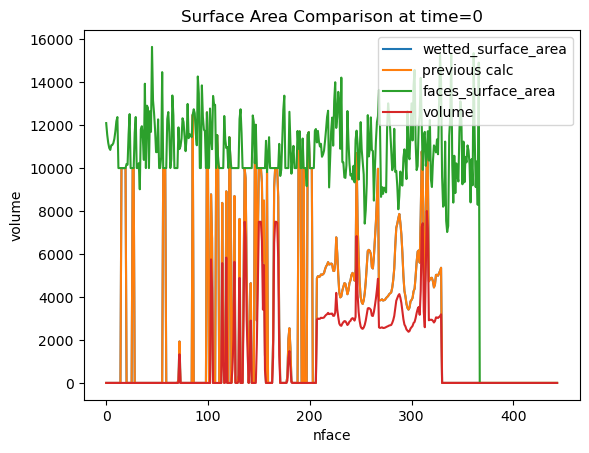

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

transport_model.mesh.wetted_surface_area.isel(time=0).plot(ax=ax, label='wetted_surface_area')
wetted_sa_subset.wetted_surface_area.isel(time=0).plot(ax=ax, label='previous calc')
transport_model.mesh.faces_surface_area.plot(ax=ax, label='faces_surface_area')
transport_model.mesh.volume.isel(time=0).plot(ax=ax, label = 'volume')

ax.legend()
plt.title("Surface Area Comparison at time=0")
plt.show()

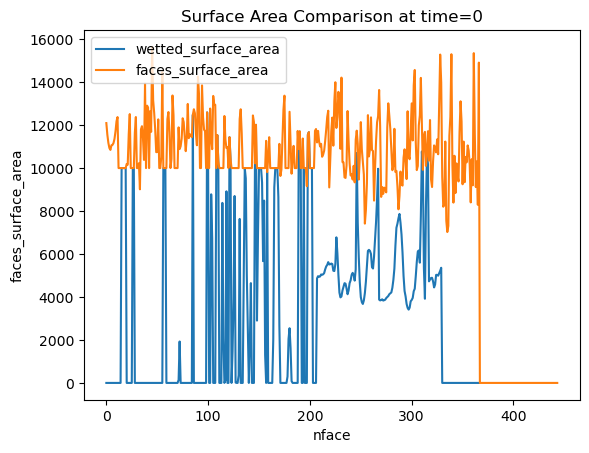

In [10]:
fig, ax = plt.subplots()

# transport_model.mesh.volume.isel(time=0).plot(ax=ax, label = 'volume')
transport_model.mesh.wetted_surface_area.isel(time=0).plot(ax=ax, label='wetted_surface_area')
transport_model.mesh.faces_surface_area.plot(ax=ax, label='faces_surface_area')

ax.legend()
plt.title("Surface Area Comparison at time=0")
plt.show()

It looks like the old calc had some calculated surface areas in cells that had no volume, so I think our new calc may be an improvement... 
however, there may be a few isseus for the cells at around 300. 

In [11]:
import numpy as np
# Select the relevant timestep
volume = transport_model.mesh.volume.isel(time=0)
wetted_sa = transport_model.mesh.wetted_surface_area.isel(time=0)

# Create mask: volume > 0 and wetted surface area == 0
mask = (volume > 0) & (wetted_sa == np.nan)

# Use the mask to see where the condition is met
problem_cells = mask.where(mask, drop=True)

problem_cells

<xarray.DataArray (nface: 0)>
array([], dtype=float64)
Coordinates:
    time     datetime64[ns] 2022-05-13
    face_x   (nface) float64 
    face_y   (nface) float64 
  * nface    (nface) int64

In [12]:
transport_model.mesh.wetted_surface_area.isel(time=0, nface=311)

<xarray.DataArray 'wetted_surface_area' ()>
array(9916.30175781)
Coordinates:
    time     datetime64[ns] 2022-05-13
    face_x   float64 5.009e+05
    face_y   float64 1.444e+03
    nface    int64 311

In [13]:
np.nanmax(lookup_dataset.isel(nface=311).wetted_surface_area)

9916.302

In [14]:
transport_model.mesh.faces_surface_area.isel(nface=311)

<xarray.DataArray 'faces_surface_area' ()>
array(9916.302, dtype=float32)
Coordinates:
    face_x   float64 5.009e+05
    face_y   float64 1.444e+03
    nface    int64 311
Attributes:
    Can Plot:  False
    Column:    ['Surface Area']
    Row:       Cell

In [15]:
transport_model.mesh.wetted_surface_area.isel(time=0, nface=311)

<xarray.DataArray 'wetted_surface_area' ()>
array(9916.30175781)
Coordinates:
    time     datetime64[ns] 2022-05-13
    face_x   float64 5.009e+05
    face_y   float64 1.444e+03
    nface    int64 311

In [16]:
transport_model.mesh.volume.isel(time=0, nface=311)

<xarray.DataArray 'volume' ()>
array(7433.698, dtype=float32)
Coordinates:
    time     datetime64[ns] 2022-05-13
    face_x   float64 5.009e+05
    face_y   float64 1.444e+03
    nface    int64 311
Attributes:
    Can Interpolate:            True
    Can Plot:                   True
    Columns:                    Cells
    Coverage:                   Wet
    Location:                   Cells
    Maximum Value of Data Set:  16477.807
    Name:                       Volume
    Orientation:                Scalar
    Rows:                       Times
    Units:                      ft^3

In [17]:
lookup_dataset.volume.isel(nface=311)

<xarray.DataArray 'volume' (lookup: 33)>
array([   0.    , 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335], dtype=float32)
Coordinates:
    nface    int64 311
  * lookup   (lookup) int32 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32

In [18]:
lookup_table = transport_model.mesh.attrs['volume_elevation_lookup']

In [19]:
lookup_table[lookup_table.Cell == 311]

,Elevation,Volume,Cell,Delta Elev,Delta Volume,Surface Area,Wetted Surface Area,lookup
0,20.000000,0.000000,311,NaN,NaN,NaN,0.000000,0
1,20.193264,1912.933472,311,0.193264,1912.933472,9898.033203,9916.301758,1


In [20]:
lookup_dataset.volume.isel(nface=311)

<xarray.DataArray 'volume' (lookup: 33)>
array([   0.    , 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335], dtype=float32)
Coordinates:
    nface    int64 311
  * lookup   (lookup) int32 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32

In [21]:
mesh = transport_model.mesh
from clearwater_riverine.variables import (
    VOLUME,
    WETTED_SURFACE_AREA
)

In [22]:
for nf in [311]:
    interp_vals = np.interp(
        mesh[VOLUME].sel(nface=nf).values, # actual volumes
        lookup_dataset[VOLUME].sel(nface=nf).values, # lookup volumes
        lookup_dataset[WETTED_SURFACE_AREA].sel(nface=nf).values, # lookup surface area
        left=lookup_dataset[WETTED_SURFACE_AREA].sel(nface=nf).values[0], # interp to lowermost value
        right=np.nanmax(lookup_dataset[WETTED_SURFACE_AREA].sel(nface=nf).values), # interp to uppermost value
    ) # shape (time,)

In [23]:
interp_vals

array([9916.30175781, 9916.30175781, 9916.30175781, 9916.30175781,
       9916.30175781, 9916.30175781, 9916.30175781, 9916.30175781,
       9916.30175781, 9916.30175781, 9916.30175781, 9916.30175781,
       9916.30175781, 9916.30175781, 9916.30175781, 9916.30175781])

In [24]:
mesh[VOLUME].sel(nface=nf).values

array([7433.698 , 7433.698 , 7433.698 , 7433.698 , 7433.698 , 7433.698 ,
       7433.6987, 7433.7036, 7433.729 , 7433.8184, 7434.04  , 7434.435 ,
       7434.9478, 7435.4307, 7435.755 , 7435.9146], dtype=float32)

In [25]:
lookup_dataset[VOLUME].sel(nface=nf).values

array([   0.    , 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335, 1912.9335,
       1912.9335, 1912.9335, 1912.9335], dtype=float32)

In [26]:
lookup_dataset[WETTED_SURFACE_AREA].sel(nface=nf).values

array([   0.   , 9916.302, 9916.302, 9916.302, 9916.302, 9916.302,
       9916.302, 9916.302, 9916.302, 9916.302, 9916.302, 9916.302,
       9916.302, 9916.302, 9916.302, 9916.302, 9916.302, 9916.302,
       9916.302, 9916.302, 9916.302, 9916.302, 9916.302, 9916.302,
       9916.302, 9916.302, 9916.302, 9916.302, 9916.302, 9916.302,
       9916.302, 9916.302, 9916.302], dtype=float32)